#### **Welcome to Assignment 6 on Deep Learning for Computer Vision.**
In this assignment you will get a chance to implement Projected Gradient Descent and Rotation Based Self Supervised Learning Technique .

#### **Instructions**
1. Use Python 3.x to run this notebook
3. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you sould not change anything else code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
4. Read documentation of each function carefully.

### Question 1 : Implement Projected Gradient Descent

Given a sample test image and a pretrained model, generate a corresponding adversarial image using Projected gradient Descent(PGD). The following attack configuration MUST be follwed in order to generate the adversarial image: step size = 2/255, epsilon = 0.3 and number_of_steps = 40. 
 
Find out the predicted class when the adversarial image generated in the previous step is fed to the pretrained model?



1.   Predicted class: 3
2.   Predicted class: 4
3.   Predicted class: 5
4.   Predicted class: 6



CUDA Available:  False
Predicted class for perturbed image:  tensor([[5]])
Mean pixel intensity of perturbed image:  0.19408265


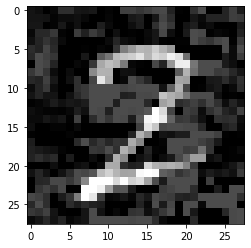

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)

epsilons = 0.3
pretrained_model = "/content/lenet_mnist_model.pth"
use_cuda=True

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
        #return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

## Implement Projected Gradient Descent algorithm

### YOUR CODE STARTS HERE
def PGD_attack(data, target, model):
        images = data
        labels = target
        iter = 40; eps = 0.3; alpha = 2 / 255 ;
        criterion_ce = nn.CrossEntropyLoss()
        ori_images = images.clone().detach()
        
        for i in range(40) :    
            images.requires_grad = True
            preds = model(images)
            cost = criterion_ce(preds,labels) 

            grad = torch.autograd.grad(cost, images, 
                                       retain_graph=False, create_graph=False)[0]

            adv_images = images + alpha*grad.sign()
            eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
            images = torch.clamp(ori_images + eta, min=int(torch.min(ori_images)), max=int(torch.max(ori_images))).detach()

        adv_images = images
        
        return adv_images 

### YOUR CODE ENDS HERE

def test( model, device, data, target, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Send the data and label to the device
    data, target = data.to(device), target.to(device)

    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True

    # Forward pass the data through the model
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    ### generate the perturbed image using PGD    
    perturbed_data = PGD_attack(data, target, model)
        
    # Re-classify the perturbed image
    output = model(perturbed_data)

    # Check for success
    final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    if final_pred.item() == target.item():
        correct += 1
    else:
        pass
    # Return the accuracy and an adversarial example
    return final_pred, perturbed_data

for data,target, in test_loader:
  data = data[0:1,:,:,:]
  target = target[0:1]
  break


pred_adv, adv_ex = test(model, device, data,target, epsilons)
print ("Predicted class for perturbed image: ",pred_adv)

### YOUR CODE STARTS HERE

## Compute mean pixel value of the perturbed image
ex = adv_ex.squeeze().detach().cpu().numpy()
z = np.mean(ex)
print ("Mean pixel intensity of perturbed image: ",z)

## Visualize the perturbed image
plt.imshow(ex, cmap="gray")

### YOUR CODE ENDS HERE

### Question 2 : Visualize The adversarial image generated  using the exactly same setup as in previous question and find out the mean pixel intensity of that adversarial image?


1.   0.1570
2.   0.1940
3.   0.2170
4.   0.2390






Please consider the modified LeNet model with below model definition:

Shared layers (1 to 4)


1.   Conv layer with 10 output channels and filter size 5
2.   Conv layer with 20 output channels and filter size 5
3.   Dropout layer
4.   Fully connected layer with output size 50
5.   Branch out 2 heads i.e. main classification and rotation  classification heads.

  *   Takes input from step 4 and outputs 10 dimensions(main class labels) through a fully connected layer
  *   Takes input from step 4 and outputs 4 dimensions(rotation class labels) through a fully connected layer

 

This model is basically a Y-shaped model where the trail is shared layers and 2 heads are for main classification and rotation classification. A model with above definition is trained for 20 epochs and the resulting trained model is shared with you. Also some steps in the forward function are kept blank for you to fill up. You have to load the model and properly write those steps in the forward function to be able to run the model. Please note that without these steps properly written, you won't be able to run the model. Once you do this, please answer the below question.

What is the model test accuracy on MNIST test dataset?

1.  92.37
2.  93.62
3.  94.49
4.  95.91

In [ ]:
# -*- coding: utf-8 -*-

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
# import matplotlib.pyplot as plt
import torch.utils.data
import numpy as np


import torchvision
import torchvision.transforms as transforms
torch.manual_seed(1)

# Assumes that tensor is (nchannels, height, width)
def tensor_rot_90(x):
    return x.flip(2).transpose(1, 2)

def tensor_rot_180(x):
    return x.flip(2).flip(1)

def tensor_rot_270(x):
    return x.transpose(1, 2).flip(2)

def rotate_batch_with_labels(batch, labels):
	images = []
	for img, label in zip(batch, labels):
		if label == 1:
			img = tensor_rot_90(img)
		elif label == 2:
			img = tensor_rot_180(img)
		elif label == 3:
			img = tensor_rot_270(img)
		images.append(img.unsqueeze(0))
	return torch.cat(images)

def rotate_batch(batch, label):
	if label == 'rand':
		labels = torch.randint(4, (len(batch),), dtype=torch.long)
	elif label == 'expand':
		labels = torch.cat([torch.zeros(len(batch), dtype=torch.long),
					torch.zeros(len(batch), dtype=torch.long) + 1,
					torch.zeros(len(batch), dtype=torch.long) + 2,
					torch.zeros(len(batch), dtype=torch.long) + 3])
		batch = batch.repeat((4,1,1,1))
	else:
		assert isinstance(label, int)
		labels = torch.zeros((len(batch),), dtype=torch.long) + label
	return rotate_batch_with_labels(batch, labels), labels

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc2_ssl = nn.Linear(50, 4)

    ### network architecture for classification head: 
    ### conv1 -> maxpool2D-> Relu->conv2->conv2_drop->maxpool2D->Relu->Reshape->fc1->Relu->dropout->fc2,fc2_ssl
    def forward(self, x):
        ### YOUR CODE STARTS HERE
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        # classification head
        out_cls = self.fc2(x)
        # self supervised head                
        out_ssl = self.fc2_ssl(x)
        return out_cls, out_ssl
        ### YOUR CODE ENDS HERE

# MNIST Test dataset and dataloader declaration
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

# the datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# Initialize the network
net = Net().to(device)

parameters = list(net.parameters())
optimizer = optim.SGD(parameters, lr=0.1, momentum=0.9, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss().to(device)
print('Running...')

def train(epoch):
    net.train()    
    
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        
        inputs, labels = inputs.to(device), labels.to(device)        
        labels_full = labels.repeat(4)            
        
        ## Self supervised head
        inputs_ssh, labels_ssh = rotate_batch(inputs, "expand")
        inputs_ssh, labels_ssh = inputs_ssh.to(device), labels_ssh.to(device)
        # outputs_clh , outputs_ssh denotes classification head output and self supervision head output respectively 
        outputs_clh, outputs_ssh = net(inputs_ssh) 
        loss = criterion(outputs_clh, labels_full)
        loss_ssh = criterion(outputs_ssh, labels_ssh)
        loss += loss_ssh

        loss.backward()
        optimizer.step()

    print(('Epoch %d: %f' %(epoch,loss.item())))
    torch.save(net, "ssl_mnist.pt")

## Funtion to compute test accuracy using model already trained with additional self-supervised head..
def test():
        ### YOUR CODE STARTS HERE
        net=torch.load("/content/ssl_mnist.pt", map_location='cpu') 
        net.eval()
        net.to(device)
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs,_ = net(inputs)
                # loss = criterion(outputs, targets)

                # test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        acc = 100.*correct/total
        print('Test Accuracy: %f' %(acc))
        ### YOUR CODE ENDS HERE

### Training Loop
#for epoch in range(0, 20):
    #train(epoch)

test()

CUDA Available:  False
Running...


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:625: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/u

Test Accuracy: 94.490000
